In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [41]:
from skimage.draw import polygon
import os
import xml.etree.ElementTree as ET
import numpy as np
from skimage.io import imread
from fastai.vision import *

## Download and unzip data

In [29]:
os.chdir('..')

In [34]:
from pathlib import Path

In [35]:
path = Path.cwd(); path

PosixPath('/Users/uwaisiqbal/Code Repositories/RASM2019')

In [7]:
(path / 'data' / 'train').mkdir(parents=True, exist_ok=True)

In [11]:
list(path.iterdir())

[PosixPath('/Users/uwaisiqbal/Code Repositories/RASM2019/notebooks/Data Preperation.ipynb'),
 PosixPath('/Users/uwaisiqbal/Code Repositories/RASM2019/notebooks/.ipynb_checkpoints'),
 PosixPath('/Users/uwaisiqbal/Code Repositories/RASM2019/notebooks/data')]

In [37]:
data_path = (path / 'data'); data_path

PosixPath('/Users/uwaisiqbal/Code Repositories/RASM2019/data')

In [15]:
# Download training set
! wget -P data_path "https://www.dropbox.com/s/plw0b1cm31np24n/RASM2019_Example_Set.zip"

--2019-03-15 10:42:26--  https://www.dropbox.com/s/plw0b1cm31np24n/RASM2019_Example_Set.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.64.1
Connecting to www.dropbox.com (www.dropbox.com)|162.125.64.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/plw0b1cm31np24n/RASM2019_Example_Set.zip [following]
--2019-03-15 10:42:27--  https://www.dropbox.com/s/raw/plw0b1cm31np24n/RASM2019_Example_Set.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb5b66607845c426a214a54097a.dl.dropboxusercontent.com/cd/0/inline/AdHxeO4d9Pg09bC_4QC8VfD7m431tlSSKrQcnFCHxSW1v0Ii4N2VqWtshyySTJDDTBzhkS3FLgBXCDMQ55Zj8XFeKkW0PHQnuswxEFgE0HzRltvGsVlmhrLEVttuoTLoxlA/file# [following]
--2019-03-15 10:42:27--  https://ucb5b66607845c426a214a54097a.dl.dropboxusercontent.com/cd/0/inline/AdHxeO4d9Pg09bC_4QC8VfD7m431tlSSKrQcnFCHxSW1v0Ii4N2VqWtshyySTJDDTBzhkS3FLgBXCDMQ55Zj8XFeKkW0PHQnuswxEFg

In [22]:
data_path / 'RASM2019_Example_Set.zip'

PosixPath('/Users/uwaisiqbal/Code Repositories/RASM2019/notebooks/data/RASM2019_Example_Set.zip')

In [24]:
# Unzip training set
! unzip -q {data_path / 'RASM2019_Example_Set.zip'} -d {path / 'train'}

unzip:  cannot find or open /Users/uwaisiqbal/Code, /Users/uwaisiqbal/Code.zip or /Users/uwaisiqbal/Code.ZIP.


## Produce masks from xml ground truth and save as images

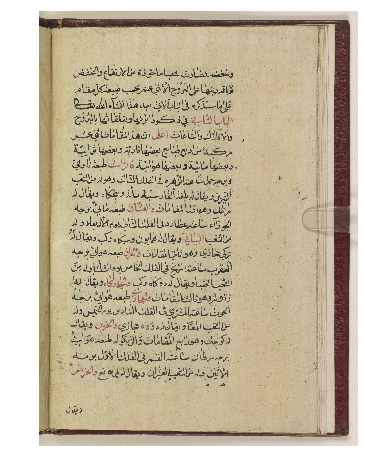

In [46]:
img_f = (data_path / 'train' / 'Add MS 23494_0031.tif')
img = open_image(img_f)
img.show(figsize=(10, 8))

In [48]:
def parse_coords(points):
    return np.array([tuple(int(p) for p in point.split(',')) for point in points.split()])

def load_xml_as_dict(path_to_file):
    tree = ET.parse(path_to_file)
    root = tree.getroot()
    SCHEMA = root.tag.split('PcGts')[0]
    metadata = root.find(f'{SCHEMA}Metadata')
    page = root.find(f'{SCHEMA}Page')
    image_info = page.attrib
    text_region_list = page.findall(f'{SCHEMA}TextRegion')
    text_region_data = []
    for text_region in text_region_list:
        text_region_id = text_region.attrib.get('id')
        text_region_type = text_region.attrib.get('type', 'page')
        text_region_coords = text_region.find(f'{SCHEMA}Coords').attrib.get('points')
        text_line_list = text_region.findall(f'{SCHEMA}TextLine')
        text_line_data = []
        for text_line in text_line_list:
            text_line_id = text_line.attrib['id']
            text_line_coords = text_line.find(f'{SCHEMA}Coords').attrib.get('points')
            text_line_text = text_line.find(f'{SCHEMA}TextEquiv')[0].text
            text_line_data.append({
                'id': text_line_id,
                'points': parse_coords(text_line_coords),
                'text': text_line_text
            })

        text_region_data.append({
            'id': text_region_id,
            'type': text_region_type,
            'points': parse_coords(text_region_coords),
            'lines': text_line_data
        })
        
    graphic_region_list = page.findall(f'{SCHEMA}GraphicRegion')
    graphic_region_data = []

    for graphic_region in graphic_region_list:
        graphic_region_id = graphic_region.attrib.get('id')
        graphic_region_coords = graphic_region.find(f'{SCHEMA}Coords').attrib.get('points')
        graphic_region_data.append({
            'id': graphic_region_id,
            'points': parse_coords(graphic_region_coords)
        })
        
    return image_info, text_region_data, graphic_region_data

class_labels = [
    'page',
    'paragraph',
    'marginalia',
    'caption',
    'graphic',
    'page-number'
    'other'
]

In [49]:
(data_path / 'train_labels').mkdir(parents=True, exist_ok=True)

In [59]:
from scipy.misc import imsave

def generate_labels(xml_file):
    print(xml_file)
    image_info, text_region_data, graphic_region_data = load_xml_as_dict(xml_file)
    image_file_name = image_info['imageFilename'].split('.')[0]
    print(image_file_name)
    im_height = int(image_info['imageHeight'])
    im_width = int(image_info['imageWidth'])
    labels = np.zeros((im_height, im_width), dtype=np.uint8)
    for text_region in text_region_data:
        points = text_region['points']
        region_type = text_region['type']
        rr, cc = polygon(points[:, 1], points[:, 0])
        labels[rr, cc] = class_labels.index(region_type)
        
    for graphic_region in graphic_region_data:
        points = graphic_region['points']
        rr, cc = polygon(points[:, 1], points[:, 0])
        labels[rr, cc] = class_labels.index('graphic')

    imsave((data_path / 'train_labels'/ f'{image_file_name}_labels.png'), labels)

In [60]:
generate_labels(data_path / 'train' /  'Add MS 7474_0032.xml')

/Users/uwaisiqbal/Code Repositories/RASM2019/data/train/Add MS 7474_0032.xml
Add MS 7474_0032


/Users/uwaisiqbal/Code Repositories/RASM2019/env/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


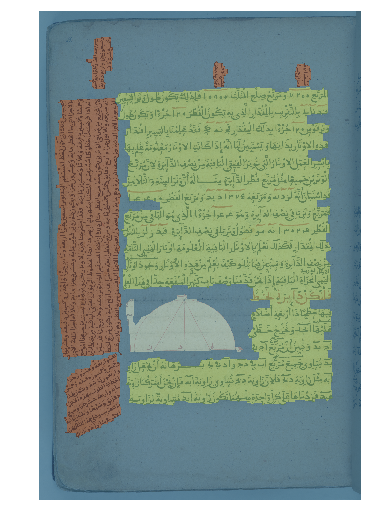

In [65]:
img = open_image(data_path / 'train' /  'Add MS 7474_0032.tif')
mask = open_mask(data_path / 'train_labels' / 'Add MS 7474_0032_labels.png' )
img.show(y=mask, figsize=(10,9))

In [66]:
# Number of images with ground truth for training
train_xml_files = [file for file in (data_path / 'train').iterdir() if file.suffix == '.xml']; len(train_xml_files)

20

In [68]:
from concurrent.futures import ProcessPoolExecutor

with ProcessPoolExecutor() as executor:
    executor.map(generate_labels, train_xml_files)

/Users/uwaisiqbal/Code Repositories/RASM2019/data/train/Delhi Arabic 1901_0036.xml
/Users/uwaisiqbal/Code Repositories/RASM2019/data/train/Delhi Arabic 1901_0154.xml
/Users/uwaisiqbal/Code Repositories/RASM2019/data/train/Delhi Arabic 1901_0155.xml
/Users/uwaisiqbal/Code Repositories/RASM2019/data/train/Or 14791_0017.xml
Delhi Arabic 1901_0036
Delhi Arabic 1901_0155
Delhi Arabic 1901_0154
Or 14791_0017
/Users/uwaisiqbal/Code Repositories/RASM2019/data/train/Add MS 7474_0028.xml
Add MS 7474_0028


/Users/uwaisiqbal/Code Repositories/RASM2019/env/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


/Users/uwaisiqbal/Code Repositories/RASM2019/data/train/Or 13006_0172.xml
Or 13006_0172


/Users/uwaisiqbal/Code Repositories/RASM2019/env/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


/Users/uwaisiqbal/Code Repositories/RASM2019/data/train/Add MS 7474_0013.xml
Add MS 7474_0013
/Users/uwaisiqbal/Code Repositories/RASM2019/data/train/Add MS 23494_0031.xml
Add MS 23494_0031
/Users/uwaisiqbal/Code Repositories/RASM2019/data/train/Or 5593_0083.xml
Or 5593_0083
/Users/uwaisiqbal/Code Repositories/RASM2019/data/train/Or 8349_0020.xml
Or 8349_0020
/Users/uwaisiqbal/Code Repositories/RASM2019/data/train/Add MS 7474_0032.xml
Add MS 7474_0032
/Users/uwaisiqbal/Code Repositories/RASM2019/data/train/Or 8349_0019.xml
Or 8349_0019


/Users/uwaisiqbal/Code Repositories/RASM2019/env/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


/Users/uwaisiqbal/Code Repositories/RASM2019/data/train/Or 3366_0111.xml
Or 3366_0111
/Users/uwaisiqbal/Code Repositories/RASM2019/data/train/Or 13006_0169.xml
Or 13006_0169
/Users/uwaisiqbal/Code Repositories/RASM2019/data/train/Add MS 7474_0043.xml
Add MS 7474_0043
/Users/uwaisiqbal/Code Repositories/RASM2019/data/train/Add MS 7474_0042.xml
Add MS 7474_0042


/Users/uwaisiqbal/Code Repositories/RASM2019/env/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


/Users/uwaisiqbal/Code Repositories/RASM2019/data/train/Or 5593_0034.xml
Or 5593_0034
/Users/uwaisiqbal/Code Repositories/RASM2019/data/train/Or 5593_0024.xml
Or 5593_0024
/Users/uwaisiqbal/Code Repositories/RASM2019/data/train/Or 5593_0033.xml
Or 5593_0033
/Users/uwaisiqbal/Code Repositories/RASM2019/data/train/Or 13006_0042.xml
Or 13006_0042
